# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



In [1]:
import numpy as np
import typing

In [2]:
import pandas as pd
import requests
import zipfile
import io, os

# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj
    
    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df

# Przykladowe użycie
#df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

# Zad 1

In [3]:
def process_raw_df(dataframe: pd.DataFrame, year: int) -> pd.DataFrame:
    df = dataframe 
    if year == 2014: #ustlamy odpowiednie nazwy kolumn, usuwamy metadane o pomiarach, plik z 2014 ma inny format.
        df.columns = df.iloc[0]
        df = df.drop([0,1,2])
    else: 
        df.columns = df.iloc[1]
        df = df.drop([0,1,2,3,4,5])
        
    df['Measurment'] = pd.to_datetime(df.iloc[:,0])  # pierwsza kolumna -> datetime
    df = df.set_index('Measurment')
    df = df.drop(columns="Kod stacji")
    df = df.apply(pd.to_numeric, errors='coerce') # zmieniamy object -> float
    
    midn_mask = df.index.hour == 0 
    corrected_dates = df.index[midn_mask] - pd.Timedelta(days=1) #wszystkie wartości z północą przesuwamy o dzien przed

    df.index.values[midn_mask] = corrected_dates 
    df = df.fillna(df.mean()) #brakujące wartości uzupełniamy średnią z całej kolumny

    return df

In [4]:
def process_metadata(metadata: pd.DataFrame) -> pd.DataFrame:
    old = 'Stary Kod stacji \n(o ile inny od aktualnego)'
    new = 'Kod stacji'
    #Niektóre wartości w metadanych to " " puste znaki, zamieniamy je na właściwe NaN
    met_old_station = metadata[old].astype(str).str.strip().replace({'nan': np.nan, '': np.nan})
    met_new_station = metadata[new].astype(str).str.strip().replace({'nan': np.nan, '': np.nan})
    metadata[old] = met_old_station
    metadata[new] = met_new_station
    #bierzemy pod uwage te wiersze gdzie zaszła zmiana kodów
    metadata = metadata.dropna(subset=[old, new])
    return metadata

In [5]:
def atomize_dict(mapper: dict[str, str]) -> dict[str, str]:
    dedup_station_map = {}
    for old_val, new_val in mapper.items():
        # Niektóre wartości rozdzielone "," np. ZpSzczecin002, ZpSzczPils02. Atomizujemy nasz dataframe.
        if old_val and ',' in old_val:
            old_codes = [code.strip() for code in str(old_val).split(',')]
            for code in old_codes:
                dedup_station_map[code] = new_val
        else:
            dedup_station_map[old_val] = new_val
    return dedup_station_map

In [6]:
def update_codes(df: pd.DataFrame, mapper: dict[str,str]) -> pd.DataFrame:
    # Używamy get, niektórych stacje, które nie zmieniały nazwy nie ma w naszym mapperze.
    df.columns = [mapper.get(col, col) for col in df.columns]
    return df

In [7]:
dfs = {}
years = [2014,2019,2024]
for year in years:
    dataframe = download_gios_archive(year, gios_url_ids[year], gios_pm25_file[year])
    print(f"Processing for {year}")
    dfs[year] = process_raw_df(dataframe, year)

/Users/ignacy/Desktop/BIOINF/ZTP/maly_projekt/.venv/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Processing for 2014
Processing for 2019
Processing for 2024


In [8]:
old_station_name = 'Stary Kod stacji \n(o ile inny od aktualnego)'
new_station_name = 'Kod stacji'

In [9]:
metadata = pd.read_excel("Metadane oraz kody stacji i stanowisk pomiarowych.xlsx")

In [10]:
filtered_metadata = process_metadata(metadata)

In [11]:
#bierzemy pod uwage te wiersze gdzie zaszła zmiana kodów
metadata_subset = filtered_metadata.dropna(subset=[old_station_name, new_station_name])

In [12]:
raw_mapper = dict(zip(metadata_subset[old_station_name],metadata_subset[new_station_name]))

In [13]:
code_mapper = atomize_dict(raw_mapper)

In [14]:
for year, df in dfs.items():
    dfs[year] = update_codes(df, code_mapper)

In [15]:
common_cols = set(dfs[2014].columns) & set(dfs[2019].columns) & set(dfs[2024].columns) #wspólne kolumny
common_cols = sorted(common_cols)

In [16]:
# Zachowujemy tylko wspólne kolumny dla wszystkich DataFrame'ów
for year, df in dfs.items():
    dfs[year] = dfs[year].loc[:, common_cols]

In [17]:
station_cities = dict(zip(metadata['Kod stacji'], metadata['Miejscowość']))

In [18]:
for year, df in dfs.items():
    new_df = df
    # Tworzymy tuple, a następnie tworzymy z nich MultiIndex
    new_df.columns = pd.MultiIndex.from_tuples([(station_cities.get(code, ''), code) for code in new_df.columns],names=['City', 'Station_Code'])
    dfs[year] = new_df

In [19]:
final_df = pd.concat([dfs[2014],dfs[2019],dfs[2024]])

In [20]:
final_df

City                     Wrocław    Bydgoszcz         Łódź       Zgierz  \
Station_Code        DsWrocAlWisn KpBydPlPozna LdLodzCzerni LdZgieMielcz   
Measurment                                                                
2014-01-01 01:00:00        152.0   116.214424    81.029259   119.696114   
2014-01-01 02:00:00        137.0    24.317504   210.364670    70.337502   
2014-01-01 03:00:00        129.0    24.317504    66.425789    40.915695   
2014-01-01 04:00:00        129.0    24.317504    53.999668    37.817917   
2014-01-01 05:00:00        105.0    24.317504    52.239670    38.814861   
...                          ...          ...          ...          ...   
2024-12-31 20:00:00         51.4     5.400000    33.300000    49.500000   
2024-12-31 21:00:00         65.5     7.700000    34.000000    48.700000   
2024-12-31 22:00:00         30.2    14.500000    31.700000    48.100000   
2024-12-31 23:00:00         36.0    12.856852    26.800000    38.400000   
2024-12-31 00:00:00         50.4    15.700000    37.300000    45.500000   

City                Zielona Góra       Kraków                 Legionowo  \
Station_Code        LuZielKrotka MpKrakAlKras MpKrakBulwar MzLegZegrzyn   
Measurment                                                                
2014-01-01 01:00:00    26.302104        104.0         64.0        44.44   
2014-01-01 02:00:00    26.302104        104.0         63.0       103.07   
2014-01-01 03:00:00    26.302104         91.0         62.0        74.91   
2014-01-01 04:00:00    26.302104         89.0         58.0        39.27   
2014-01-01 05:00:00    26.302104         83.0         55.0        26.51   
...                          ...          ...          ...          ...   
2024-12-31 20:00:00    15.900000         57.0         43.2        22.20   
2024-12-31 21:00:00    16.100000         58.7         54.1        34.50   
2024-12-31 22:00:00    15.900000         67.9         55.8        32.20   
2024-12-31 23:00:00    12.500000         75.3         69.5        30.80   
2024-12-31 00:00:00    14.700000         75.5         72.6        30.30   

City                       Płock        Radom  ...     Żyrardów  \
Station_Code        MzPlocMiReja MzRadTochter  ... MzZyraRoosev   
Measurment                                     ...                
2014-01-01 01:00:00    24.337662     58.67000  ...    28.154729   
2014-01-01 02:00:00    24.337662     40.07000  ...    28.154729   
2014-01-01 03:00:00    24.337662     32.72000  ...    28.154729   
2014-01-01 04:00:00    24.337662     27.44000  ...    28.154729   
2014-01-01 05:00:00    24.337662     28.01000  ...    28.154729   
...                          ...          ...  ...          ...   
2024-12-31 20:00:00    33.000000     37.20000  ...    27.300000   
2024-12-31 21:00:00    29.400000     34.60000  ...    29.400000   
2024-12-31 22:00:00    29.300000     16.96156  ...    30.400000   
2024-12-31 23:00:00    27.900000     23.50000  ...    30.500000   
2024-12-31 00:00:00    25.500000     21.00000  ...    27.900000   

City                Kędzierzyn-Koźle     Przemyśl       Gdańsk     Katowice  \
Station_Code            OpKKozBSmial PkPrzemGrunw PmGdaLeczkow SlKatoKossut   
Measurment                                                                    
2014-01-01 01:00:00            115.0       48.175         58.4        104.0   
2014-01-01 02:00:00            134.0       33.747         28.5        107.0   
2014-01-01 03:00:00            137.0       30.622         27.0        114.0   
2014-01-01 04:00:00            137.0       28.642         28.7        108.0   
2014-01-01 05:00:00            136.0       27.781         25.7         88.0   
...                              ...          ...          ...          ...   
2024-12-31 20:00:00             18.6       19.700         11.2         20.3   
2024-12-31 21:00:00             22.9       19.300         14.0         20.1   
2024-12-31 22:00:00             25.6       17.400         15.8         27.3   
2024-12-31 

# Zad 2
## Średnie miesięczne + trend dla miast
Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

In [21]:
import matplotlib.pyplot as plt

# Obliczamy średnie miesięczne dla każdego roku i stacji
monthly_means = {}
for year, df in dfs.items():
    # Pogrupowanie danych po miesiącu ('M' - Month) i obliczenie średniej
    monthly_means[year] = df.resample('ME').mean()

print("Średnie miesięczne dla 2024:")
display(monthly_means[2024].head())

Średnie miesięczne dla 2024:


City              Wrocław    Bydgoszcz         Łódź       Zgierz Zielona Góra  \
Station_Code DsWrocAlWisn KpBydPlPozna LdLodzCzerni LdZgieMielcz LuZielKrotka   
Measurment                                                                      
2024-01-31      24.596505    16.511633    19.619823    34.505862    13.538924   
2024-02-29      16.550228    14.257362    15.918045    23.865174    13.415730   
2024-03-31      24.230258    21.968228    21.435484    29.892339    27.340566   
2024-04-30      11.900294    11.422439     9.913945    14.103417    14.041281   
2024-05-31      11.552390    10.963754    13.078406     9.043983    18.868175   

City               Kraków                 Legionowo        Płock        Radom  \
Station_Code MpKrakAlKras MpKrakBulwar MzLegZegrzyn MzPlocMiReja MzRadTochter   
Measurment                                                                      
2024-01-31      24.649096    26.220534    20.167339    18.128495    21.586115   
2024-02-29      21.751479    19.795690    16.914368    15.890517    18.350287   
2024-03-31      27.488596    25.849731    22.576344    22.519086    23.902967   
2024-04-30      15.380721    14.007361    11.695096    11.159306    14.127725   
2024-05-31      13.249866    10.771237     9.503495     9.852688    11.302130   

City          ...     Żyrardów Kędzierzyn-Koźle     Przemyśl       Gdańsk  \
Station_Code  ... MzZyraRoosev     OpKKozBSmial PkPrzemGrunw PmGdaLeczkow   
Measurment    ...                                                           
2024-01-31    ...    20.336629        26.152957    22.494243    16.545353   
2024-02-29    ...    17.753305        13.536207    20.950287    15.184226   
2024-03-31    ...    25.430446        20.068145    23.720452    22.547130   
2024-04-30    ...    11.655789         9.398472    13.023194    15.129782   
2024-05-31    ...     9.775237         8.037396    10.668683    14.450538   

City             Katowice  Złoty Potok      Olsztyn       Kalisz     Szczecin  \
Station_Code SlKatoKossut SlZlotPotLes WmOlsPuszkin WpKaliSawick ZpSzczAndrze   
Measurment                                                                      
2024-01-31      25.719624    17.096281    18.509409    24.507392    11.504704   
2024-02-29      18.910776    13.307087    16.142241    18.619253     9.038050   
2024-03-31      24.651210    20.759991    21.389382    28.007966    25.609543   
2024-04-30      13.398333    11.420000    12.789583    13.471250     9.186202   
2024-05-31      14.880374     8.643413    12.669892    12.682661     9.609409   

City                       
Station_Code ZpSzczPilsud  
Measurment                 
2024-01-31      14.529032  
2024-02-29      13.539511  
2024-03-31      28.622839  
2024-04-30      13.884444  
2024-05-31      14.005511  

[5 rows x 23 columns]

In [22]:
# Przygotowanie danych do wykresu dla Warszawy i Katowic
cities_to_plot = ['Warszawa', 'Katowice']
years_to_plot = [2014, 2024]
trends_data = {}

for year in years_to_plot:
    df_monthly = monthly_means[year]
    city_monthly_means = df_monthly.groupby(level='City', axis=1).mean()
    for city in cities_to_plot:
        if city in city_monthly_means.columns:
            trends_data[(city, year)] = city_monthly_means[city]

print("Dane do wykresu trendów dla Warszawy i Katowic:")
display(pd.DataFrame(trends_data).head())
display(pd.DataFrame(trends_data).tail())

Dane do wykresu trendów dla Warszawy i Katowic:


/var/folders/d8/w39s4pfn1r7bx7sn0b5r72g80000gn/T/ipykernel_31571/4151661044.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  city_monthly_means = df_monthly.groupby(level='City', axis=1).mean()
/var/folders/d8/w39s4pfn1r7bx7sn0b5r72g80000gn/T/ipykernel_31571/4151661044.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  city_monthly_means = df_monthly.groupby(level='City', axis=1).mean()


,Warszawa,Katowice,Warszawa,Katowice
,2014,2014,2024,2024
Measurment,,,,
2014-01-31,30.254099,45.385395,NaN,NaN
2014-02-28,42.577734,56.745159,NaN,NaN
2014-03-31,34.794175,42.790180,NaN,NaN
2014-04-30,24.720824,27.036380,NaN,NaN
2014-05-31,17.529557,14.957218,NaN,NaN


,Warszawa,Katowice,Warszawa,Katowice
,2014,2014,2024,2024
Measurment,,,,
2024-08-31,NaN,NaN,10.097146,11.948790
2024-09-30,NaN,NaN,14.525739,13.956111
2024-10-31,NaN,NaN,15.373106,16.799194
2024-11-30,NaN,NaN,17.678627,22.538056
2024-12-31,NaN,NaN,17.317070,30.312903


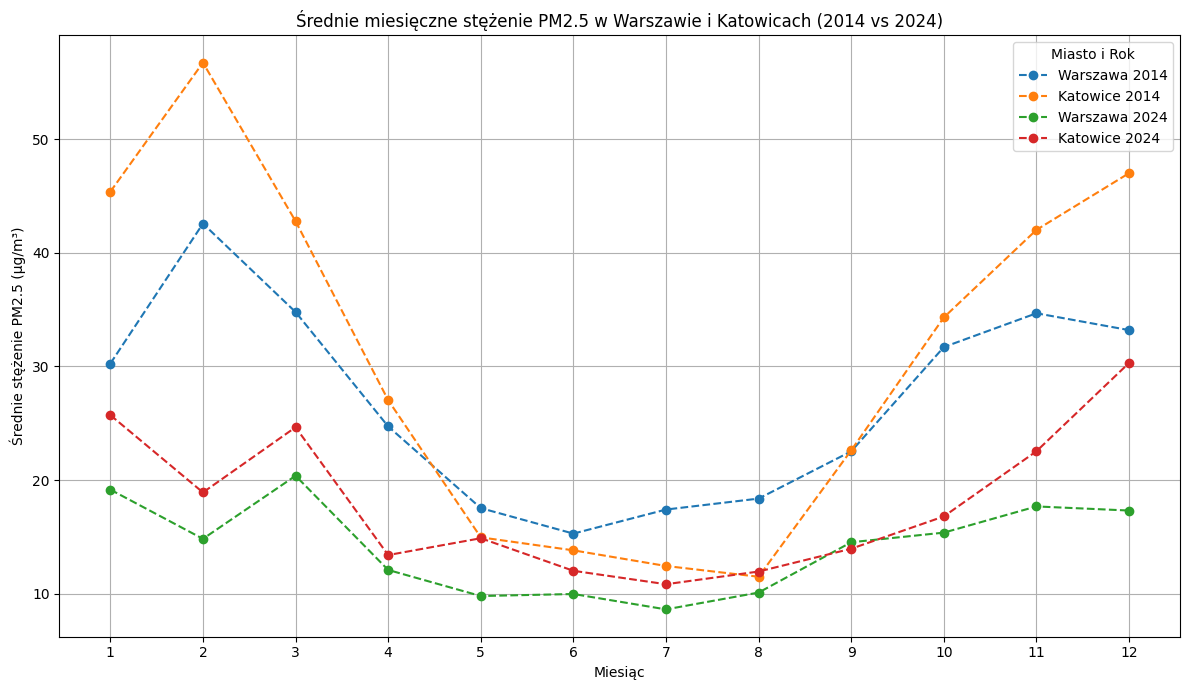

In [23]:
# Rysowanie wykresu trendów
fig, ax = plt.subplots(figsize=(12, 7))

for (city, year), data in trends_data.items():
    # Miesiące na osi X
    months = range(1, 13)
    ax.plot(months, data.values, marker='o', linestyle='--', label=f'{city} {year}')

# Ustawienia wykresu
ax.set_title('Średnie miesięczne stężenie PM2.5 w Warszawie i Katowicach (2014 vs 2024)')
ax.set_xlabel('Miesiąc')
ax.set_ylabel('Średnie stężenie PM2.5 (µg/m³)')
ax.set_xticks(months)
ax.legend(title='Miasto i Rok')
ax.grid(True)

plt.tight_layout()
plt.show()

## Interpretacja zadania 2-ego
Po pierwsze możemy zauważyć, że w niektórych miesiącach poziomy zanieczyszczeń są o wiele większe niż innych np. w okresach zimowych średnie stężenie PM2.5 (najwyższy odczyt w lutym) jest zauważalnie większe niż w okresie letnim. To oczywiście spowodowane jest paleniem min. w piecach w gospodarstwach domowych.
Co ciekawsze w latach 2014 ogólny średni poziom zanieczysczeń jest większy niż w latach 2024 (linie trendu są wyżej), możemy, więc zauważyć efekty przepisów mających na celu ochronę środowiska, a także wymianę min. starych pieców grzewczych na nowe.
Ostatnią sprawą może być to, że średni poziom PM2.5 jest mniejszy w Warszawie niżeli w Katowicach (być może spowodowane tym, że na Śląsku w gospodarstwach domowych więcej było pieców węglowych).


# Zad 3
## Heatmapa miesięcznych średnich
Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

In [24]:
# Łączymy dane
all_dfs = []
for year, df in dfs.items():
    # Dodajemy kolumnę z rokiem
    df_year = df.copy()
    df_year['Year'] = year
    all_dfs.append(df_year.reset_index())

combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df = combined_df.set_index(['Measurment', 'Year'])

print("Informacje o połączonym DataFrame:")
combined_df

Informacje o połączonym DataFrame:


City                          Wrocław    Bydgoszcz         Łódź       Zgierz  \
Station_Code             DsWrocAlWisn KpBydPlPozna LdLodzCzerni LdZgieMielcz   
Measurment          Year                                                       
2014-01-01 01:00:00 2014        152.0   116.214424    81.029259   119.696114   
2014-01-01 02:00:00 2014        137.0    24.317504   210.364670    70.337502   
2014-01-01 03:00:00 2014        129.0    24.317504    66.425789    40.915695   
2014-01-01 04:00:00 2014        129.0    24.317504    53.999668    37.817917   
2014-01-01 05:00:00 2014        105.0    24.317504    52.239670    38.814861   
...                               ...          ...          ...          ...   
2024-12-31 20:00:00 2024         51.4     5.400000    33.300000    49.500000   
2024-12-31 21:00:00 2024         65.5     7.700000    34.000000    48.700000   
2024-12-31 22:00:00 2024         30.2    14.500000    31.700000    48.100000   
2024-12-31 23:00:00 2024         36.0    12.856852    26.800000    38.400000   
2024-12-31 00:00:00 2024         50.4    15.700000    37.300000    45.500000   

City                     Zielona Góra       Kraków                 Legionowo  \
Station_Code             LuZielKrotka MpKrakAlKras MpKrakBulwar MzLegZegrzyn   
Measurment          Year                                                       
2014-01-01 01:00:00 2014    26.302104        104.0         64.0        44.44   
2014-01-01 02:00:00 2014    26.302104        104.0         63.0       103.07   
2014-01-01 03:00:00 2014    26.302104         91.0         62.0        74.91   
2014-01-01 04:00:00 2014    26.302104         89.0         58.0        39.27   
2014-01-01 05:00:00 2014    26.302104         83.0         55.0        26.51   
...                               ...          ...          ...          ...   
2024-12-31 20:00:00 2024    15.900000         57.0         43.2        22.20   
2024-12-31 21:00:00 2024    16.100000         58.7         54.1        34.50   
2024-12-31 22:00:00 2024    15.900000         67.9         55.8        32.20   
2024-12-31 23:00:00 2024    12.500000         75.3         69.5        30.80   
2024-12-31 00:00:00 2024    14.700000         75.5         72.6        30.30   

City                            Płock        Radom  ...     Żyrardów  \
Station_Code             MzPlocMiReja MzRadTochter  ... MzZyraRoosev   
Measurment          Year                            ...                
2014-01-01 01:00:00 2014    24.337662     58.67000  ...    28.154729   
2014-01-01 02:00:00 2014    24.337662     40.07000  ...    28.154729   
2014-01-01 03:00:00 2014    24.337662     32.72000  ...    28.154729   
2014-01-01 04:00:00 2014    24.337662     27.44000  ...    28.154729   
2014-01-01 05:00:00 2014    24.337662     28.01000  ...    28.154729   
...                               ...          ...  ...          ...   
2024-12-31 20:00:00 2024    33.000000     37.20000  ...    27.300000   
2024-12-31 21:00:00 2024    29.400000     34.60000  ...    29.400000   
2024-12-31 22:00:00 2024    29.300000     16.96156  ...    30.400000   
2024-12-31 23:00:00 2024    27.900000     23.50000  ...    30.500000   
2024-12-31 00:00:00 2024    25.500000     21.00000  ...    27.900000   

City                     Kędzierzyn-Koźle     Przemyśl       Gdańsk  \
Station_Code                 OpKKozBSmial PkPrzemGrunw PmGdaLeczkow   
Measurment          Year                                              
2014-01-01 01:00:00 2014            115.0       48.175         58.4   
2014-01-01 02:00:00 2014            134.0       33.747         28.5   
2014-01-01 03:00:00 2014            137.0       30.622         27.0   
2014-01-01 04:00:00 2014            137.0       28.642         28.7   
2014-01-01 05:00:00 2014            136.0       27.781         25.7   
...                                   ...          ...          ...   
2024-12-31 20:00:00 2024             18.6       19.700         11.2   
2024-12-31 21:00:00 2024             22

In [25]:
# Przekształcamy dane do formatu 'long' dla łatwiejszego grupowania
df_long = combined_df.stack(level=['City', 'Station_Code']).reset_index()
df_long.rename(columns={0: 'PM25_Value'}, inplace=True)

# Dodajemy kolumnę z miesiącem
df_long['Month'] = df_long['Measurment'].dt.month

# Grupujemy dane po mieście, roku i miesiącu, obliczając średnią
city_monthly_avg = df_long.groupby(['City', 'Year', 'Month'])['PM25_Value'].mean().reset_index()

print("Średnie miesięczne dla miast:")
display(city_monthly_avg.head())

/var/folders/d8/w39s4pfn1r7bx7sn0b5r72g80000gn/T/ipykernel_31571/2388081278.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = combined_df.stack(level=['City', 'Station_Code']).reset_index()


Średnie miesięczne dla miast:


,City,Year,Month,PM25_Value
0,Bydgoszcz,2014,1,29.363421
1,Bydgoszcz,2014,2,43.865041
2,Bydgoszcz,2014,3,36.801971
3,Bydgoszcz,2014,4,20.511295
4,Bydgoszcz,2014,5,13.038032


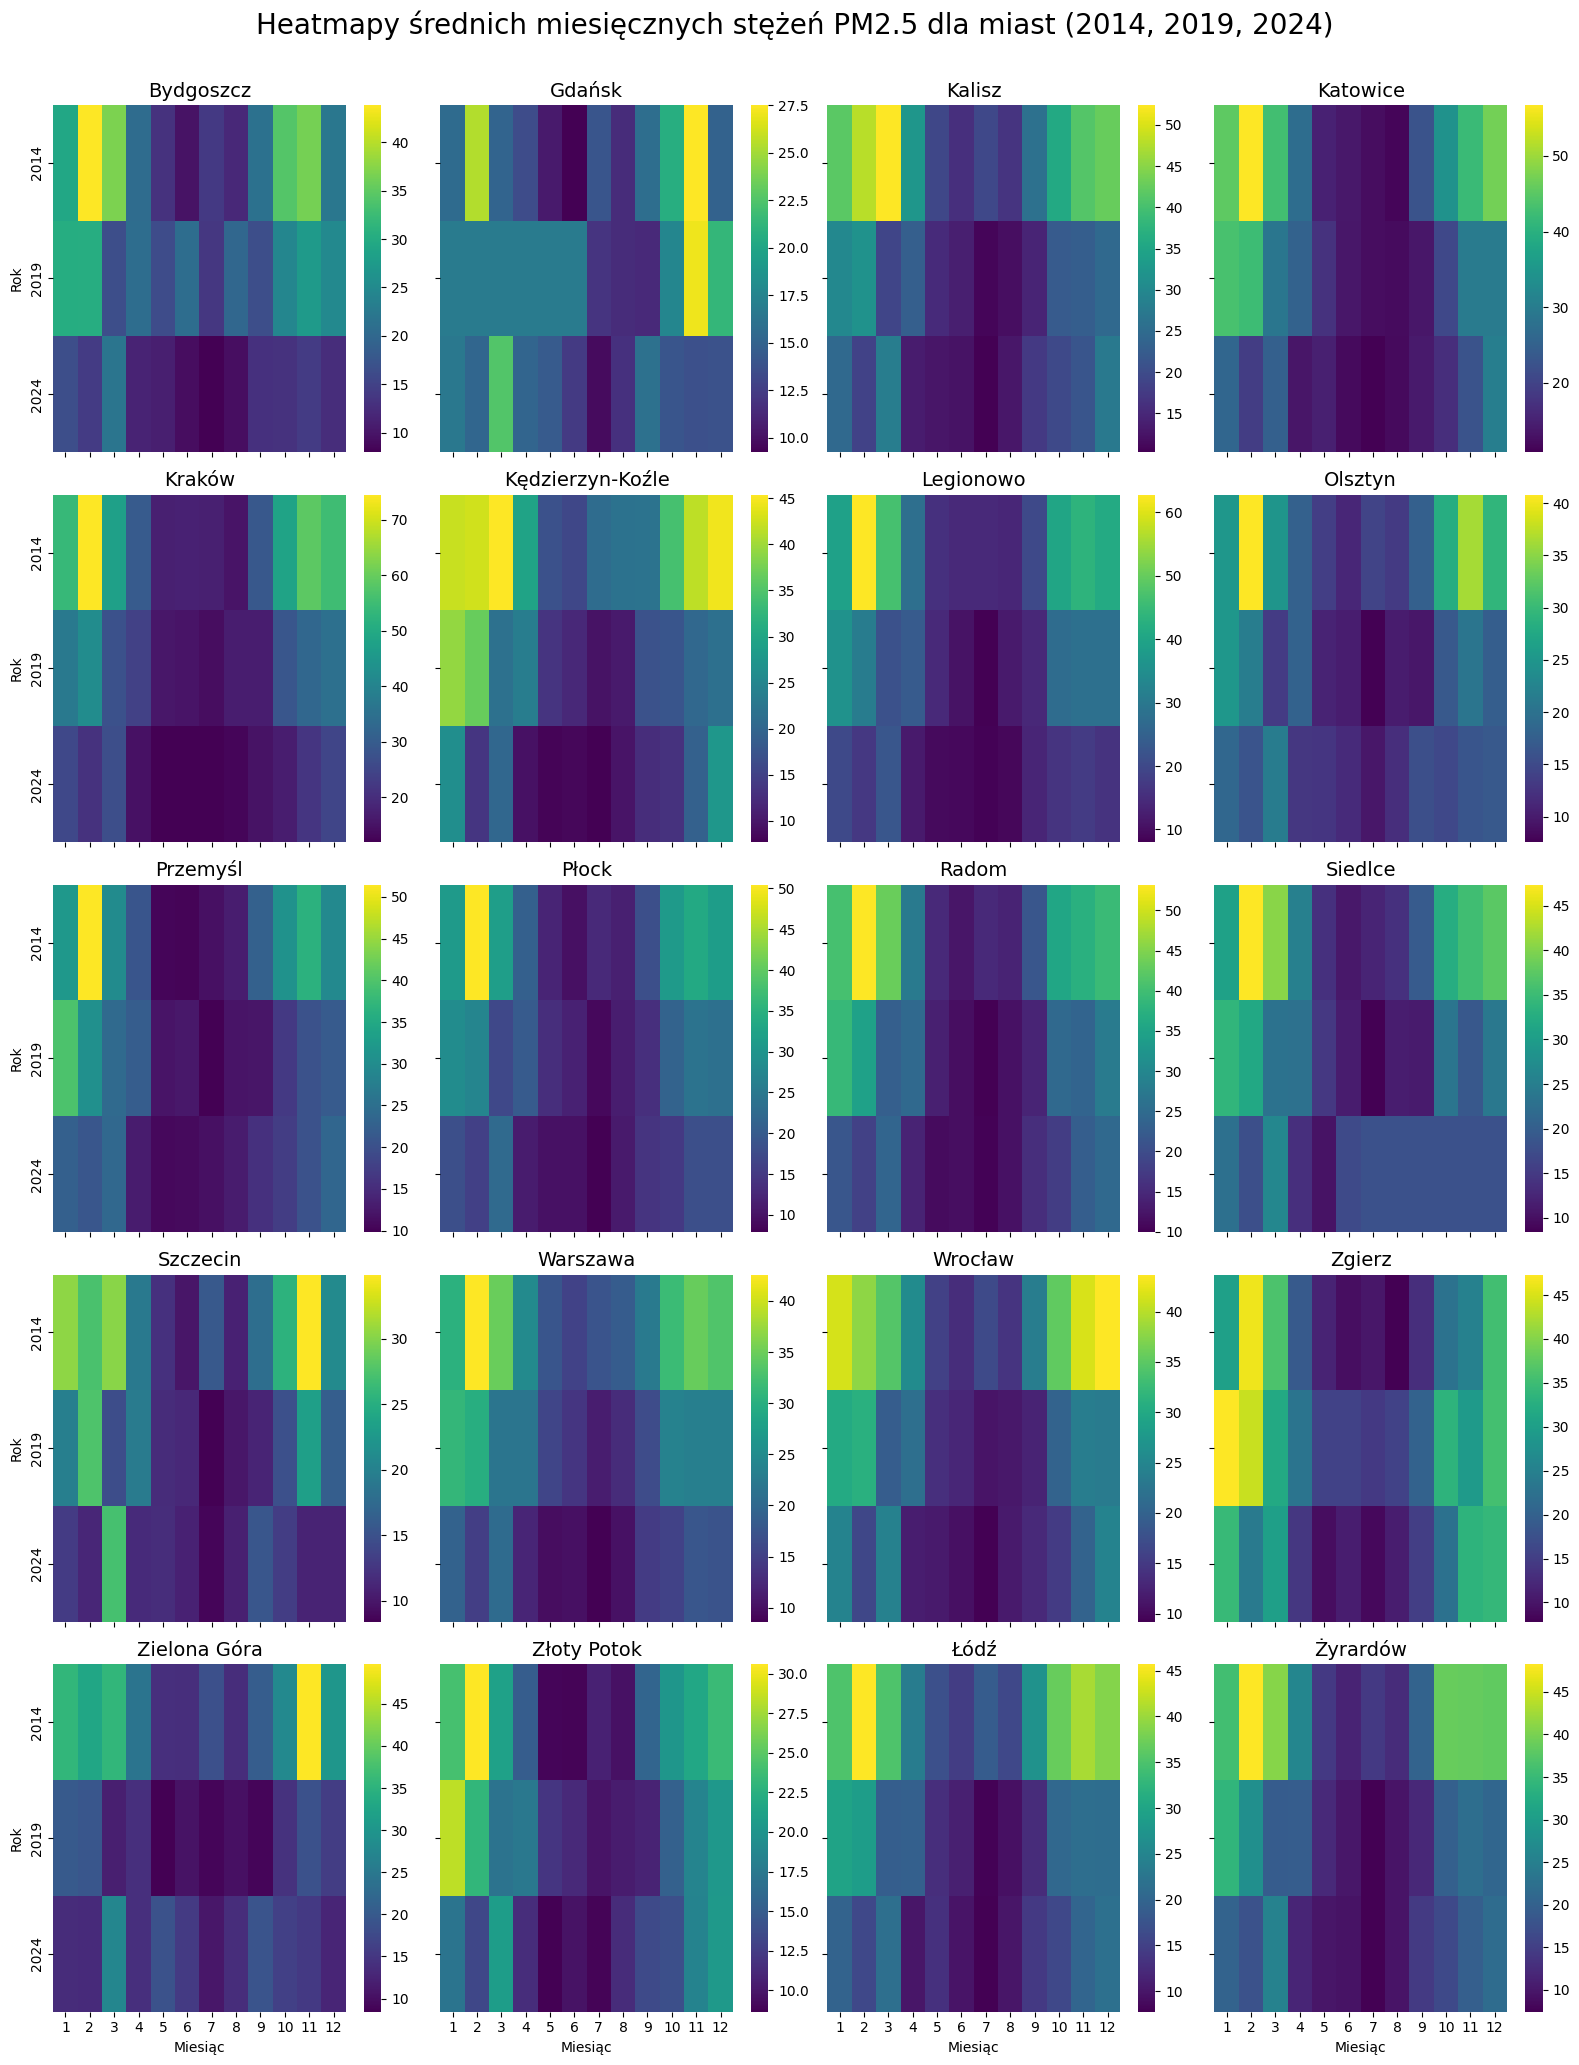

In [26]:
import seaborn as sns

# Tworzymy FacetGrid, gdzie każdy panel to jedno miasto
g = sns.FacetGrid(city_monthly_avg, col="City", col_wrap=4, height=4)

# Mapujemy heatmapę na każdy panel
g.map_dataframe(
    lambda data, color: sns.heatmap(
        data.pivot(index='Year', columns='Month', values='PM25_Value'),
        cmap='viridis'
    )
)

g.set_titles("{col_name}", size=14)
g.set_axis_labels("Miesiąc", "Rok")
g.figure.suptitle('Heatmapy średnich miesięcznych stężeń PM2.5 dla miast (2014, 2019, 2024)', size=20, y=1.03)

plt.show()

## Interpretacja zadania 3-ego
Z tego wykresu jasno widać, że ogólna sytuacja z zanieczyszceniem PM2.5 ulega poprawieniu - widać to min. w Warszawie, Katowicach czy Szczecinie. Są jednak wyjątki, w Siedlcach nastąpiło znaczne pogorszenie warunków, a w Zgierzu także było więcej dni przekraczających normy. Ogólnie średnio widzimy mimo wszystko, że rok 2014 był najgorszy pod tym względem. 

Można zaobserwować również podobne trendy do tych wyłaniających się z poprzedniego zadania. Dla większości miast stężenia cząstek PM2.5 są najwyższe od września do kwietnia. Zmniejszają się one również w kolejnych rozpatrywanych co 5 latach. Z trendów tych najbardziej wyłamuje się Zgierz w którym stężenia wzrosły między rokiem 2014 a 2019 i pozostały relatywnie wysokie w roku 2024.

# Zad 4
## Dni z przekroczeniem normy (WHO)
Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

In [31]:
# Norma dobowa WHO dla PM2.5
WHO_NORM = 15

# Obliczamy średnie dobowe dla każdej stacji i roku
daily_means = {}
for year, df in dfs.items():
    daily_means[year] = df.resample('D').mean()

# Liczymy dni z przekroczeniem normy
exceeding_days = {}
for year, df_daily in daily_means.items():
    exceeding_days[year] = (df_daily > WHO_NORM).sum()

# Konwertujemy wyniki do DataFrame dla łatwiejszej analizy
exceeding_df = pd.DataFrame(exceeding_days)
exceeding_df = exceeding_df.reset_index()

print("Liczba dni z przekroczeniem normy:")
display(exceeding_df.head())

Liczba dni z przekroczeniem normy:


,City,Station_Code,2014,2019,2024
0,Wrocław,DsWrocAlWisn,274,181,136
1,Bydgoszcz,KpBydPlPozna,240,243,105
2,Łódź,LdLodzCzerni,300,186,128
3,Zgierz,LdZgieMielcz,191,265,199
4,Zielona Góra,LuZielKrotka,260,106,150


In [32]:
# Wybieramy 3 stacje z najmniejszą i 3 z największą liczbą dni z przekroczeniem w 2024
exceeding_2024 = exceeding_df.sort_values(by=2024)

# 3 stacje z najmniejszą liczbą dni
bottom_3_stations = exceeding_2024.head(3)
# 3 stacje z największą liczbą dni
top_3_stations = exceeding_2024.tail(3)

selected_stations = pd.concat([bottom_3_stations, top_3_stations])
selected_station_codes = selected_stations['Station_Code'].tolist()

print("3 stacje z najmniejszą liczbą dni z przekroczeniem normy w 2024:")
display(bottom_3_stations)
print("\n3 stacje z największą liczbą dni z przekroczeniem normy w 2024:")
display(top_3_stations)

3 stacje z najmniejszą liczbą dni z przekroczeniem normy w 2024:


,City,Station_Code,2014,2019,2024
21,Szczecin,ZpSzczAndrze,200,116,72
12,Warszawa,MzWarWokalna,244,170,102
1,Bydgoszcz,KpBydPlPozna,240,243,105



3 stacje z największą liczbą dni z przekroczeniem normy w 2024:


,City,Station_Code,2014,2019,2024
17,Katowice,SlKatoKossut,259,237,185
3,Zgierz,LdZgieMielcz,191,265,199
10,Siedlce,MzSiedKonars,246,206,287


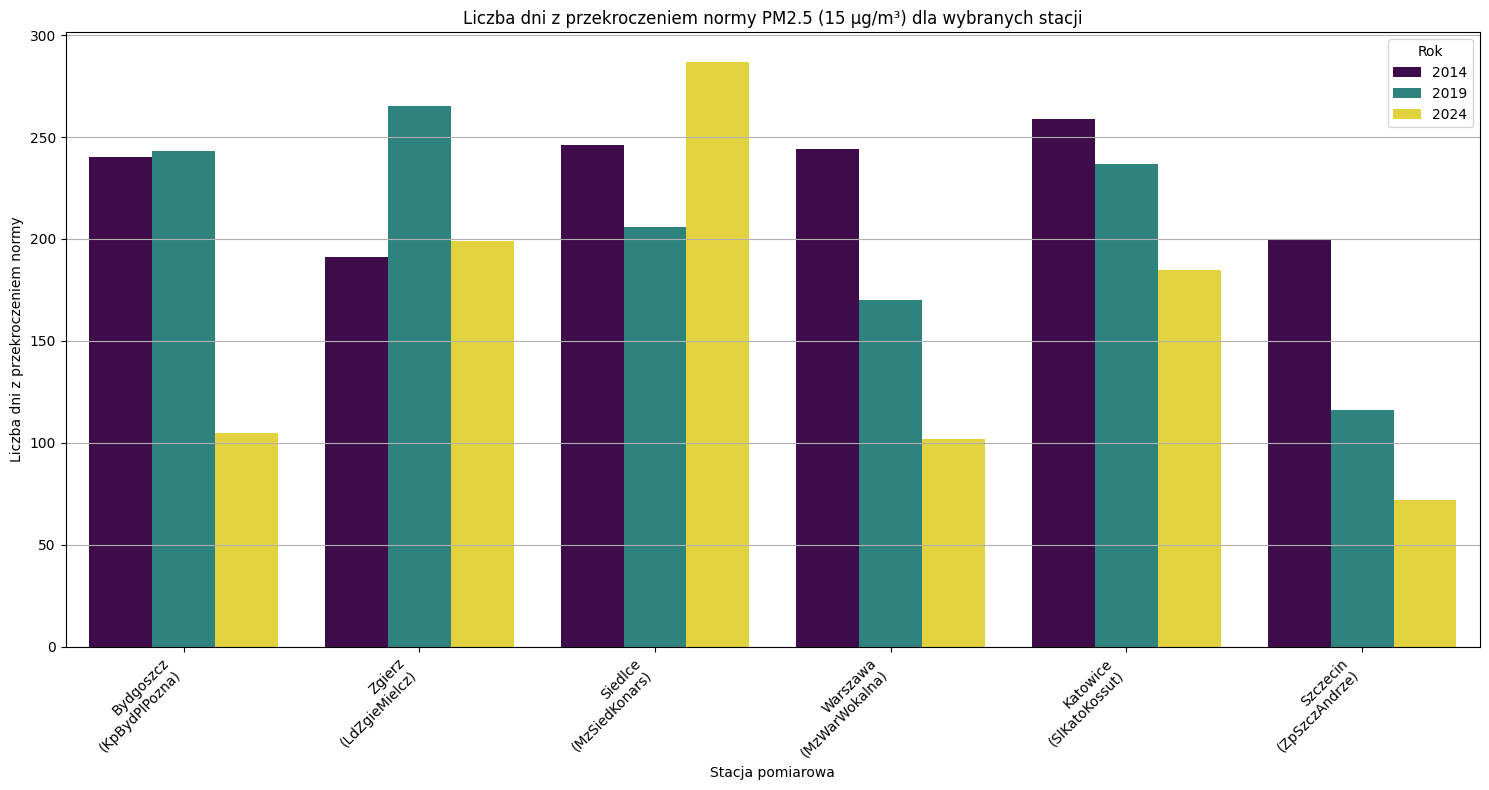

In [29]:
plot_data = exceeding_df[exceeding_df['Station_Code'].isin(selected_station_codes)]

# Przekształcamy dane do formatu 'long'
plot_data_long = plot_data.melt(
    id_vars=['City', 'Station_Code'],
    value_vars=[2014, 2019, 2024],
    var_name='Year',
    value_name='Exceeding_Days'
)

# Tworzymy etykiety dla osi X łącząc miasto i kod stacji
plot_data_long['Station_Label'] = plot_data_long['City'] + '\n(' + plot_data_long['Station_Code'] + ')'

# Rysowanie wykresu
plt.figure(figsize=(15, 8))
sns.barplot(
    data=plot_data_long,
    x='Station_Label',
    y='Exceeding_Days',
    hue='Year',
    palette='viridis'
)

plt.title('Liczba dni z przekroczeniem normy PM2.5 (15 µg/m³) dla wybranych stacji')
plt.xlabel('Stacja pomiarowa')
plt.ylabel('Liczba dni z przekroczeniem normy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Rok')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## Interpretacja zadania 4-ego 
W 2014 różnice między miastami były znacznie mniejsze. Najmniej dni w których została przekroczona 
norma emisji (poniej 200) w wybranych miast miał wtedy Zgierz a najwięcej Katowice (ponad 250). Obraz ten zmienia się w 2024, gdzie różnica pomiędzy Siedlcami a Szczecinem wyniosła już około 200 dni. Z uwagi na zaobserowany już w poprzednich zadaniach spadek emisji w większości miast sytuacja na przestrzeni 10 lat uległa zmianie. Dwa z trzech miast o nawyższej liczbie dni z przkroczoną normą w 2024 znotowały ich wzrost na przestrzeni 10 lat, natomiast w trzecim przypadku (Katowice), wynik ten można przypisać wysokiemu efektowi bazy. W przypadku najlepiej wypadających miast w 2014 liczba zanieczyszczonych dni nie była dużo większa (maksymalnie ~60) od pozostałych. Relatywny sukces można przypisać, więc raczej spadkom emisji PM2.5, potencjanie związanym np. z wysiłkami termomodernizacyjnymi.